In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

from cuqipy_cil.model import FanBeam2DModel
from cuqi.array import CUQIarray
from cuqi.geometry import Image2D
from cuqi.distribution import Gaussian, Gamma, LMRF, JointDistribution
from cuqi.sampler import UGLA, Conjugate, ConjugateApprox, Gibbs

import subprocess
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [2]:
import cuqi
import cuqipy_cil
import cil 
print('cuqi version: ', cuqi.__version__)
print('cuqipy_cil version: ', cuqipy_cil.__version__)
print('cil version: ', cil.__version__)


cuqi version:  0.8.0.post0.dev13
cuqipy_cil version:  0.6.0
cil version:  23.0.1


In [3]:
cuqipy_cil.config.PROJECTION_BACKEND = "astra"
cuqipy_cil.config.PROJECTION_BACKEND_DEVICE = "gpu"

## 4. Case study: X-ray computed tomography with the CUQIpy-CIL plugin

In this case study we specify a CT problem with the CUQIpy-CIL plugin and solve it using CUQIpy's UQ tools.

We use a dataset from HTC 2022. It is available at https://zenodo.org/record/6937616#.YzrjoGdBybg and described at https://www.fips.fi/HTCdata.php#anchor1. 


In [4]:
import os
import urllib.request

url = 'https://zenodo.org/record/6937616/files/htc2022_tb_full.mat?download=1'
filename = 'htc2022_tb_full.mat'
if not os.path.exists(filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Downloaded file!')

Below we load the dataset and its parameters describing the scan geometry. 

To make the data compatible with CUQIpy we load it into a CUQIarray and equip it with Image2D geometry.

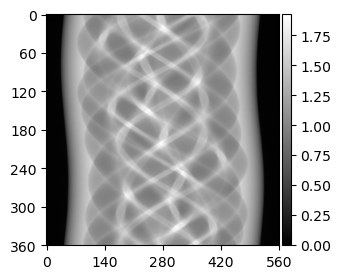

In [5]:
# Acquisition data and geometry parameters
mat = scipy.io.loadmat("htc2022_tb_full.mat")
sinogram_full = mat['CtDataFull'][0][0][1].astype('float32')
num_dets = int(mat['CtDataFull'][0][0][2][0][0][32][0][0])
source_center = mat['CtDataFull'][0][0][2][0][0][6][0][0].astype('float32')
source_detector = mat['CtDataFull'][0][0][2][0][0][7][0][0].astype('float32')
det_pixel_size = mat['CtDataFull'][0][0][2][0][0][30][0][0].astype('float32')
mag = mat['CtDataFull'][0][0][2][0][0][9][0][0].astype('float32')
angles_original = mat['CtDataFull'][0][0][2][0][0][11][0].astype('float32')

# Choose number of angles and angular range
# The full dataset has a (0,360) angular range and 721 view angles. 
num_angles = 360 
range_angles = (0,360) # python syntax, so endpoint is not included

# Subsample sinogram and projection angles
sinogram = sinogram_full[int(range_angles[0]*2):int(range_angles[1]*2):int((range_angles[1]-range_angles[0])*2/num_angles),:].flatten(order="C")
angles = angles_original[int(range_angles[0]*2):int(range_angles[1]*2):int((range_angles[1]-range_angles[0])*2/num_angles)]

# Wrap data in CUQIpy geometry
y_obs = CUQIarray(sinogram, is_par=True, geometry=Image2D((num_angles, num_dets)))

# Plot sinogram
fig, ax = plt.subplots(1,1, figsize=(3,3))
cs = y_obs.plot(aspect = 'auto')
cax = fig.add_axes([cs[0].axes.get_position().x1+0.01,cs[0].axes.get_position().y0,0.03,cs[0].axes.get_position().height])
cbar = plt.colorbar(cs[0], cax=cax)
cs[0].axes.set_xticks([0,140,280,420,560])
cs[0].axes.set_yticks(np.linspace(0,360, 7, endpoint = True))

#### 4.1. Model
The CT linear forward model can be setup convinently with the cil-plugin to CUQIpy. 

In [6]:
# Define CT model conveniently with cil-plugin
N = 500 # reconstruction dimension NxN
A = FanBeam2DModel(det_count=num_dets, 
                        det_spacing = det_pixel_size,
                        angles=-angles/180*np.pi,
                        source_object_dist = source_center,
                        object_detector_dist = source_detector - source_center,
                        domain = (det_pixel_size*num_dets/mag, det_pixel_size*num_dets/mag),
                        im_size = (N,N)) 

print(A)

CUQI FanBeam2DModel: Image2D(250000,) -> Image2D(201600,).
    Forward parameters: ['x'].


#### 4.2. The Bayesian Problem

To formulate the Baysian Problem we must define a prior and data distribution. In CT we can assume that the data is distributed according to a Gaussian. The data precision $s$ is unknown, so we model it as a random hyperparameter distributed according to a Gamma. We choose a LMRF prior for the image, which is an edge-preserving prior. The prior precision $d$ is also unknown, and thus modelled as a random hyperparameter distributed according to a Gamma. 

This makes a so-called hierachical problem and it is specified in CUQIpy:

In [7]:
# Hyperpriors, prior and data distribution in hierarchical structure
# Note we use lambda functions here, but direct algebraic expressions are part of next release.
d = Gamma(shape=1, rate=1e-4)
s = Gamma(shape=1, rate=1e-4)
y = Gaussian(mean=A, cov=lambda s: 1/s)
x = LMRF(location=np.zeros(A.domain_dim), scale=lambda d: 1/d, geometry=A.domain_geometry)

#### 4.3. Posterior sampling and analysis

To solve the Bayesian Problem we form the joint distribution of the random variables and condition on the observed data to obtain the posterior distribution:

In [8]:
posterior = JointDistribution(y, x, s, d)(y = y_obs)

To sample from the posterior distribution we utilize the hierarchial structure and apply a Gibbs sampler. The Gibbs sampler iteratively sample from the conditional distributions of the random variables. Below we specify the Gibbs sampler, and what sampler should be used to sample from each conditional distribution.

In [9]:
# Samplers for each parameter
sampling_strategy = {
    'd': ConjugateApprox,
    's': Conjugate,
    'x': UGLA}

# Gibbs sampler on p(d,s,x|y=y_obs)
sampler_Gibbs = Gibbs(posterior, sampling_strategy)

Below we run the sampler. Please check that GPU is available.

In [10]:
# Run sampler
np.random.seed(1000)
st = time.time()
samples_Gibbs = sampler_Gibbs.sample(500,100)
et = time.time()-st
print("Time: {}".format(et))

Warmup 100 / 100
Sample 500 / 500
Time: 5947.553848743439


We visualize some simple statistics of the posterior samples. For the image, we plot the mean and standard deviation of the $\bm{x}$ samples, and for the hyperparameters $s$ and $d$, we plot the 1D marginals and chains using .traceplot().

The $\bm{x}$ posterior mean shows a point estimate representing a good reconstruction of the CT data, and the $\bm{x}$ posterior std shows our confidence in the reconstruction and that we are most uncertain near edges in the image. The traceplots of $d$ and $s$ show well mixed chains and that the posteriors have constracted with fairly high certainty close to $449$ and $9340$ respectively.

/data/conda/envs/cil/lib/python3.10/site-packages/cuqi/samples/_samples.py:680: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight_layout: plt.tight_layout()
/data/conda/envs/cil/lib/python3.10/site-packages/cuqi/samples/_samples.py:680: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight_layout: plt.tight_layout()


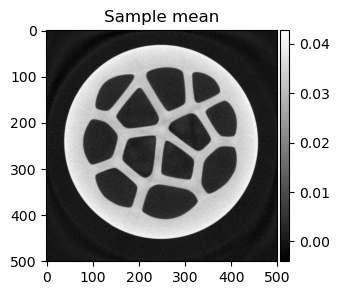

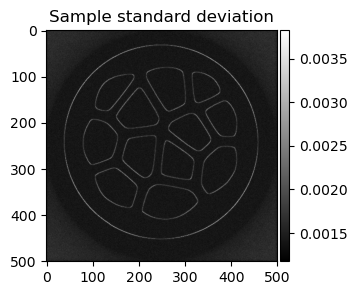

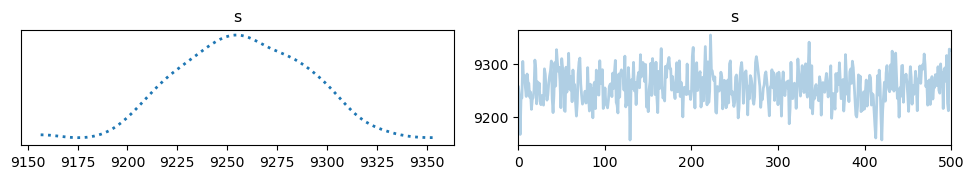

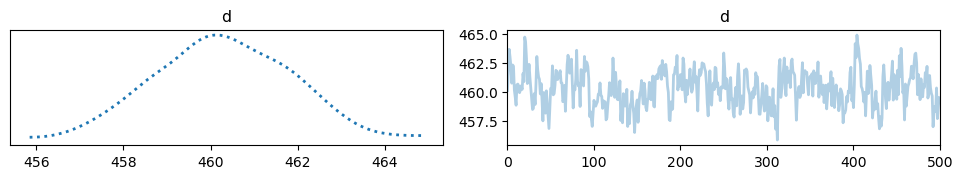

In [11]:
# Plot x mean
fig, ax = plt.subplots(1,1, figsize=(3,3))
cs = samples_Gibbs["x"].plot_mean()
cax = fig.add_axes([cs[0].axes.get_position().x1+0.01,cs[0].axes.get_position().y0,0.03,cs[0].axes.get_position().height])
cbar = plt.colorbar(cs[0], cax=cax)
cs[0].axes.set_xticks([0,100,200,300,400,500])
cs[0].axes.set_yticks([0,100,200,300,400,500])

# Plot x std
fig, ax = plt.subplots(1,1, figsize=(3,3))
cs = samples_Gibbs["x"].plot_std()
cax = fig.add_axes([cs[0].axes.get_position().x1+0.01,cs[0].axes.get_position().y0,0.03,cs[0].axes.get_position().height])
cbar = plt.colorbar(cs[0], cax=cax)
cs[0].axes.set_xticks([0,100,200,300,400,500])
cs[0].axes.set_yticks([0,100,200,300,400,500])

# Plot posterior s samples
fig, axs = plt.subplots(nrows = 1, ncols = 2, squeeze = False, figsize = (12,1.5), gridspec_kw = {'wspace': 0.15})
samples_Gibbs["s"].plot_trace(trace_kwargs = {'lw': 2}, plot_kwargs= {'lw': 2}, axes = axs)
axs[0,1].set_xticks([0,100,200,300,400,500])

# Plot posterior d samples
fig, axs = plt.subplots(nrows = 1, ncols = 2, squeeze = False, figsize = (12,1.5), gridspec_kw = {'wspace': 0.15})
samples_Gibbs["d"].plot_trace(trace_kwargs = {'lw': 2}, plot_kwargs= {'lw': 2}, axes = axs)
axs[0,1].set_xticks([0,100,200,300,400,500])